# 1. 语言模型

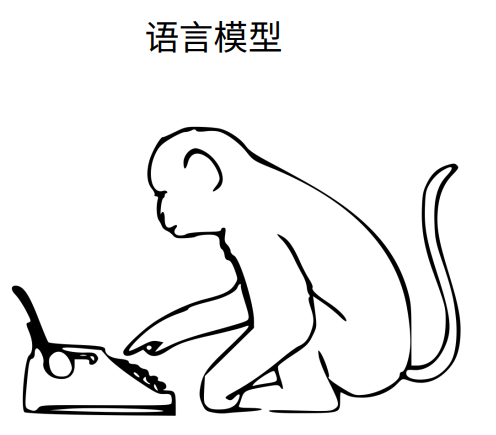

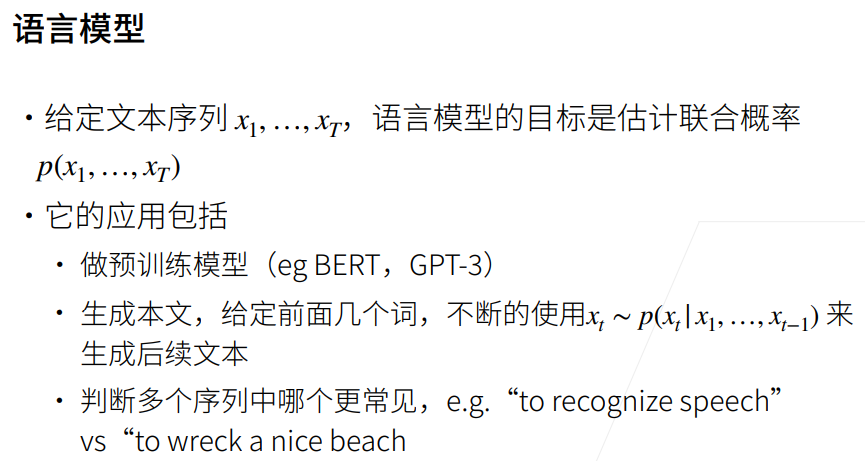

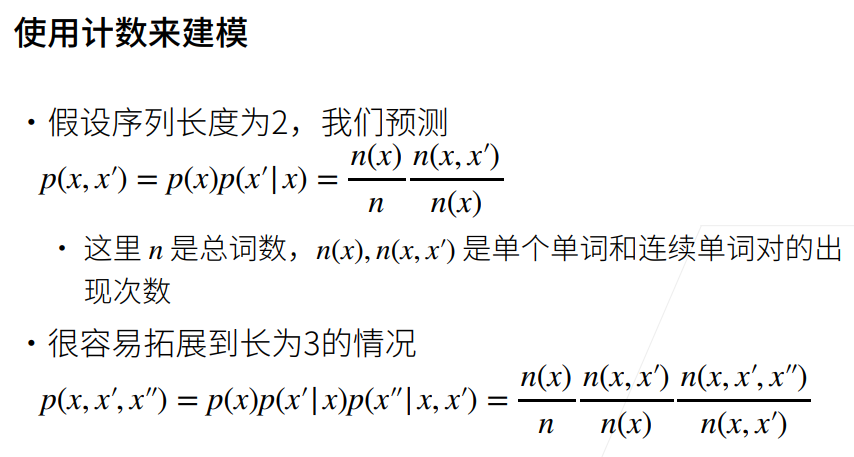

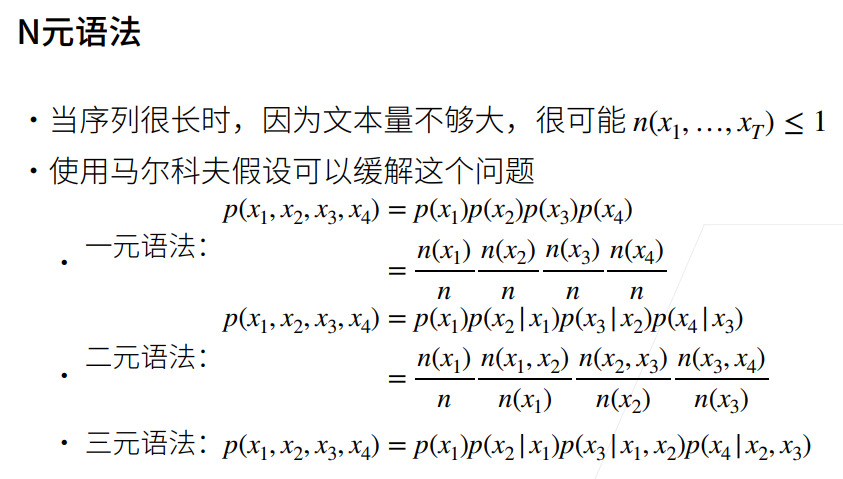

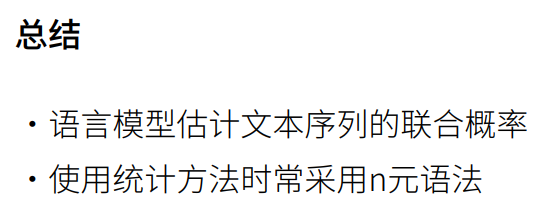

# 2. 语言模型

In [1]:
# 导入random模块，用于生成随机数
import random 
# 导入torch模块，用于深度学习任务
import torch
# 导入d2l库中的torch模块别名
from d2l import torch as d2l

# 使用d2l库中的函数读取时间机器文本，并进行分词处理
tokens = d2l.tokenize(d2l.read_time_machine())
# 将tokens中的所有单词连接成一个列表，生成语料库corpus
corpus = [token for line in tokens for token in line]
# 使用语料库corpus构建词汇表vocab
vocab = d2l.Vocab(corpus)
# 输出词汇表中出现频率最高的前10个单词和对应的频率
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

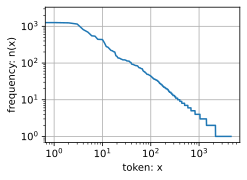

In [2]:
# 最流行的词被称为停用词画出的词频图
# 从词汇表的token_freqs中提取频率信息，存储在列表freqs中
freqs = [freq for token, freq in vocab.token_freqs]
# 使用d2l库中的plot函数绘制词频图
# 设置横轴为token，纵轴为对应的频率，横轴使用对数刻度，纵轴也使用对数刻度
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')   

In [3]:
# 其他的词元组合，比如二元语法、三元语法等等，又会如何呢？
# 使用列表推导式将corpus中的相邻两个词组成二元语法的词元组合，存储在bigram_tokens列表中     
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])] # 二元语法
# 使用bigram_tokens构建二元语法的词汇表bigram_vocab
bigram_vocab = d2l.Vocab(bigram_tokens)
# 输出二元语法词汇表中出现频率最高的前10个词元组合和对应的频率
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [4]:
# 三元语法
# 使用列表推导式将corpus中的相邻三个词组成三元语法的词元组合，存储在trigram_tokens列表中
trigram_tokens = [triple for triple in zip(corpus[:-2],corpus[1:-1],corpus[2:])]   
# 使用trigram_tokens构建三元语法的词汇表trigram_vocab
trigram_vocab = d2l.Vocab(trigram_tokens)
# 输出三元语法词汇表中出现频率最高的前10个词元组合和对应的频率
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

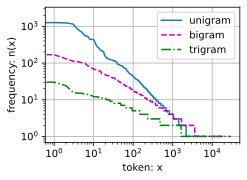

In [5]:
# 直观地对比三种模型中的标记频率
# 从bigram词汇表的token_freqs中提取频率信息，存储在列表bigram_freqs中
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
# 从trigram词汇表的token_freqs中提取频率信息，存储在列表trigram_freqs中
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
# 使用d2l库中的plot函数绘制标记频率对比图
# 将bigram和trigram的频率信息传入plot函数，横轴为token，纵轴为对应的频率
# 横轴和纵轴都使用对数刻度，同时在图例中标明每个模型的名称
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
        ylabel='frequency: n(x)', xscale='log', yscale='log',
        legend=['unigram','bigram','trigram'])

In [6]:
# 随即生成一个小批量数据的特征和标签以供读取
# 在随即采样中，每个样本都是在原始的长序列上任意捕获的子序列

# 给一段很长的序列，连续切成很多段长为T的子序列
# 一开始加了一点随即，使得每次切的都不一样
# 取随即批量的时候，再随即把它们取出来
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随即抽样生成一个小批量子序列"""
    # 从原始序列中随机选择一个起始位置
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 计算能够生成的子序列数量
    num_subseqs = (len(corpus) - 1) // num_steps
    # 创建初始索引列表
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 进行随机打乱
    random.shuffle(initial_indices)
    
    # 返回从指定位置开始的长度为num_steps的子序列
    def data(pos):
        return corpus[pos:pos + num_steps]
    
    # 计算批次的数量
    num_batches = num_subseqs // batch_size
    # 对每个批次进行迭代
    for i in range(0, batch_size * num_batches, batch_size):
        # 获取当前批次的初始索引列表
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        # 根据初始索引列表获取对应的特征序列X
        X = [data(j) for j in initial_indices_per_batch]
        # 根据初始索引列表获取对应的标签序列Y
        Y = [data(j+1) for j in initial_indices_per_batch]
        # 使用torch.tensor将X和Y转换为张量，并通过yield语句返回
        yield torch.tensor(X), torch.tensor(Y)

In [7]:
# 生成一个从0到34的序列
my_seq = list(range(35))
# 使用seq_data_iter_random函数生成随机抽样的小批量特征和标签数据
# batch_size=2表示每个批次的样本数量为2
# num_steps=5表示每个样本的长度为5
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY: ', Y) # Y是X长度的后一个，X里面的两个不一定是连续的

X:  tensor([[20, 21, 22, 23, 24],
        [10, 11, 12, 13, 14]]) 
Y:  tensor([[21, 22, 23, 24, 25],
        [11, 12, 13, 14, 15]])
X:  tensor([[15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29]]) 
Y:  tensor([[16, 17, 18, 19, 20],
        [26, 27, 28, 29, 30]])
X:  tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]]) 
Y:  tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]])


In [8]:
# 保证两个相邻的小批量中的子序列在原始序列上也是相邻的
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 随机选择一个偏移量作为起始位置
    offset = random.randint(0, num_steps)
    # 计算可以生成的子序列的总长度
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    # 创建特征序列X的张量
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    # 创建标签序列Y的张量
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    # 重新调整Xs和Ys的形状，使其成为(batch_size, -1)的二维张量
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    # 计算可以生成的批次数量
    num_batches = Xs.shape[1] // num_steps
    # 对每个批次进行迭代
    for i in range(0, num_steps * num_batches, num_steps):
        # 获取当前批次的特征序列X
        X = Xs[:, i:i + num_steps]
        # 获取当前批次的标签序列Y
        Y = Ys[:, i:i + num_steps]
        # 使用yield语句返回X和Y作为生成器的输出
        yield X, Y

In [9]:
# 读取每个小批量的子序列的特征X和标签Y
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    # 第二个小批量的起始位置是接着第一个小批量的结束位置后面的
    print('X: ', X, '\nY: ', Y) # 第二个mini-batch[9-13]是接着第一个mini-batch[3-7]后面       

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [10]:
class SeDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        # 根据use_random_iter选择数据迭代函数
        if use_random_iter:
            # 使用随机分区迭代器
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            # 使用顺序分区迭代器
            self.data_iter_fn = d2l.seq_data_iter_sequential
        # 加载数据集和词汇表
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        # 设置批量大小和步长
        self.batch_size, self.num_steps = batch_size, num_steps
        
    def __iter__(self):
        # 返回数据迭代器
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)   

In [11]:
# 最后，定义一个函数 load_data_time_machine，它同时返回数据迭代器和词汇表
def load_data_time_machine(batch_size, num_steps, use_random_iter = False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表"""
    # 这个对象将作为数据的迭代器，用于产生小批量的样本和标签。
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)   
    # 返回数据迭代器和对应的词汇表
    return data_iter, data_iter.vocab